# precipitation extremes and precipitation (pr)

In [1]:
import intake
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

import os

import myFuncs
import myPlots


#import dask
#dask.config.set(**{'array.slicing.split_large_chunks': True})

# precipitation data

In [2]:
models = [
        # 'IPSL-CM5A-MR', # 1
         'GFDL-CM3',     # 2
        # 'GISS-E2-H',    # 3
        # 'bcc-csm1-1',   # 4
        # 'CNRM-CM5',     # 5
        # 'CCSM4',        # 6 # cannot concatanate files for historical run
        # 'HadGEM2-AO',   # 7
        # 'BNU-ESM',      # 8
        # 'EC-EARTH',     # 9
        # 'FGOALS-g2',    # 10
        # 'MPI-ESM-MR',   # 11
        # 'CMCC-CM',      # 12
        # 'inmcm4',       # 13
        # 'NorESM1-M',    # 14
        # 'CanESM2',      # 15 # slicing with .sel does not work, 'contains no datetime objects'
        # 'MIROC5',       # 16
        # 'HadGEM2-CC',   # 17
        # 'MRI-CGCM3',    # 18
        # 'CESM1-BGC'     # 19
        ]


model = models[0] #'GFDL-CM3'


historical = True
rcp85 = False

if historical:
    experiment = 'historical'
    period=slice('1970-01','1999-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r6i1p1'


if rcp85:
    experiment = 'rcp85'
    period=slice('2070-01','2099-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r2i1p1'


ds_dict = intake.cat.nci['esgf'].cmip5.search(
                                model_id = model, 
                                experiment = 'historical',
                                time_frequency = 'day', 
                                realm = 'atmos', 
                                ensemble = 'r1i1p1', 
                                variable= 'pr').to_dataset_dict()

if not (model == 'CanESM2' and experiment == 'historical'):
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].sel(time=period, lon=slice(0,360),lat=slice(-35,35))
else:
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].isel(time=slice(43800, 43800+10950)).sel(lon=slice(0,360),lat=slice(-35,35))


# print(ds_pr.pr.encoding), will show that missing values are represented as 1e+20, although importing it with intake converts them to nan


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.product.institute_id.model_id.experiment.time_frequency.realm.cmor_table.ensemble.version.variable'


In [3]:
ds_orig

<xarray.Dataset>
Dimensions:     (time: 10950, bnds: 2, lat: 36, lon: 144)
Coordinates:
  * time        (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat         (lat) float64 -35.0 -33.0 -31.0 -29.0 ... 29.0 31.0 33.0 35.0
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
    lat_bnds    (lat, bnds) float64 -36.0 -34.0 -34.0 -32.0 ... 34.0 34.0 36.0
    lon_bnds    (lon, bnds) float64 0.0 2.5 2.5 5.0 ... 355.0 357.5 357.5 360.0
    pr          (time, lat, lon) float32 dask.array<chunksize=(1825, 36, 144), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(1825,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(1825,), meta=np.ndarray>
Attributes: (12/28)
    institution:             NOAA GFDL(201 Forrestal Rd, Princeton, NJ, 08540)
    comment:                 GFDL experiment name: CM3Z_D1_1860-2005_AllForc_...
    forcing:                 GHG,SA,Oz,LU,Sl,Vl,SS,BC,MD,OC (GHG includes CO2...
    model_id:                GFDL-CM3
    history:                 File was processed by fremetar (GFDL analog of C...
    institute_id:            NOAA GFDL
    ...                      ...
    project_id:              CMIP5
    physics_version:         1
    modeling_realm:          atmos
    parent_experiment_rip:   r1i1p1
    experiment:              historical
    intake_esm_dataset_key:  cmip5.output1.NOAA-GFDL.GFDL-CM3.historical.day....

In [4]:
haveDsOut = True
ds_pr = myFuncs.regrid_conserv(ds_orig, haveDsOut) # path='', model'')

In [5]:
ds_pr

<xarray.Dataset>
Dimensions:  (time: 10950, lat: 22, lon: 128)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(1825, 22, 128), meta=np.ndarray>
Attributes:
    regrid_method:  conservative

In [6]:
precip = ds_pr.pr*60*60*24
precip.attrs['units']= 'mm/day'
precip

<xarray.DataArray 'pr' (time: 10950, lat: 22, lon: 128)>
dask.array<mul, shape=(10950, 22, 128), dtype=float32, chunksize=(1825, 22, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm/day

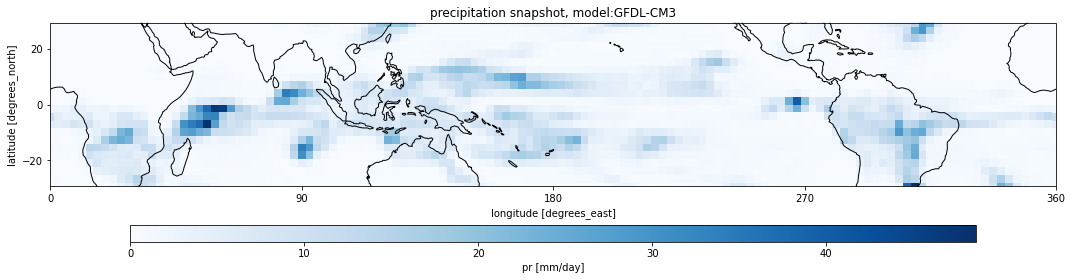

In [7]:
myPlots.plot_snapshot(precip.isel(time=0), 'Blues', 'precipitation', model)

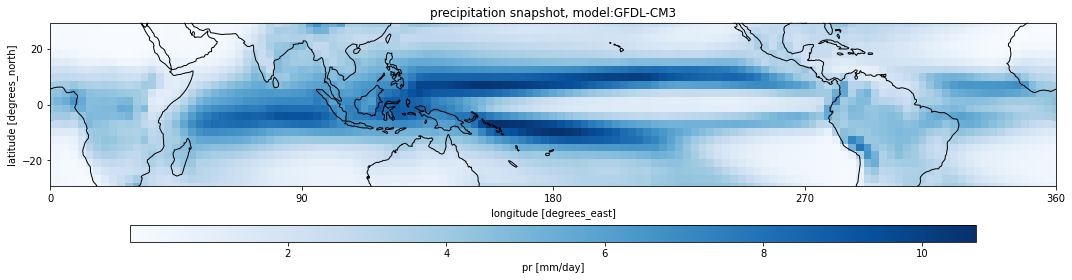

In [8]:
myPlots.plot_snapshot(precip.mean(dim='time', keep_attrs=True), 'Blues', 'precipitation', model)

# precipitation extremes metrics

## rx1day, rx5day 

In [10]:
rx1day = precip.resample(time='Y').max(dim='time') # needs to be weighted later when taking the spatial mean

precip5day = precip.resample(time='5D').mean(dim='time')
rx5day = precip5day.resample(time='Y').max(dim='time')

In [11]:
# as function
def calc_rxday(precip):
    rx1day = precip.resample(time='Y').max(dim='time')

    precip5day = precip.resample(time='5D').mean(dim='time')
    rx5day = precip5day.resample(time='Y').max(dim='time')

    return rx1day, rx5day

In [28]:
# np.array_equal(precip.resample(time='5D').mean(dim='time').resample(time='Y').max(dim='time'),rx5day)

: 

: 

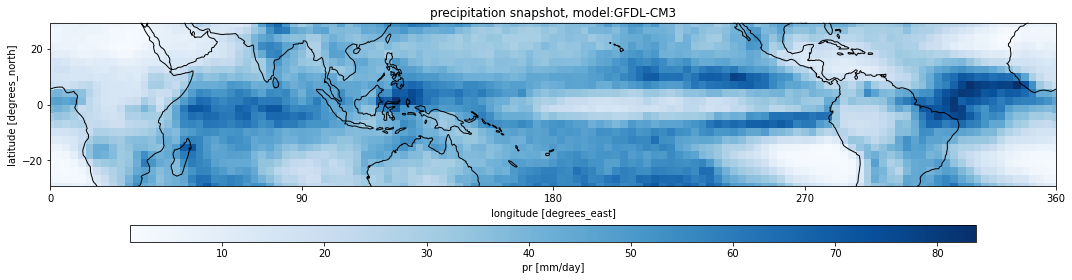

In [12]:
myPlots.plot_snapshot(rx1day.mean(dim=('time'),keep_attrs=True), 'Blues', 'precipitation', model)

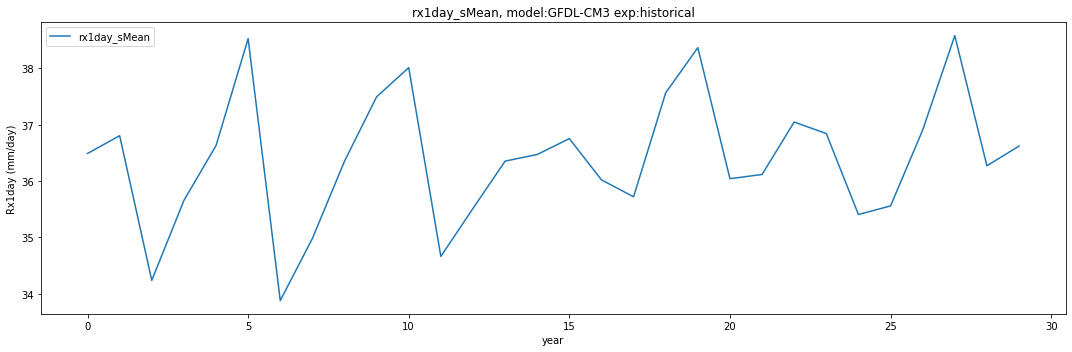

In [13]:
f, ax = plt.subplots(figsize=(15, 5))

da = xr.DataArray(rx1day.mean(dim=('lat','lon'),keep_attrs=True).data)
da.plot(ax=ax, label='rx1day_sMean')
ax.set_title('rx1day_sMean, model:' + model + ' exp:' + experiment)
ax.set_ylabel('Rx1day (mm/day)')
ax.set_xlabel('year')
ax.legend(loc = 'upper left')

plt.tight_layout()

## extreme percentiles

In [14]:
pr_95 = precip.quantile(0.95,dim=('lat','lon'),keep_attrs=True)
pr_95 = xr.DataArray(
    data=pr_95.data,
    dims=['time'],
    coords={'time': precip.time.data},
    attrs={'units':'mm/day'}
    )

pr_97 = precip.quantile(0.97,dim=('lat','lon'),keep_attrs=True)
pr_97 = xr.DataArray(
    data=pr_97.data,
    dims=['time'],
    coords={'time': precip.time.data},
    attrs={'units':'mm/day'}
    )

pr_99 = precip.quantile(0.99,dim=('lat','lon'),keep_attrs=True)
pr_99 = xr.DataArray(
    data=pr_99.data,
    dims=['time'],
    coords={'time': precip.time.data},
    attrs={'units':'mm/day'}
    )

pr_999 = precip.quantile(0.999,dim=('lat','lon'),keep_attrs=True)
pr_999 = xr.DataArray(
    data=pr_999.data,
    dims=['time'],
    coords={'time': precip.time.data},
    attrs={'units':'mm/day'}
    )

# mean precipitaion in gridboxes over percentile threshold
# pr_99mean = precip.where(precip>pr_99).mean(dim=('lat','lon'))
# pr_99mean.attrs['units'] = 'mmm/day'

In [15]:
# as function
def calc_percentiles():
    pr_95 = precip.quantile(0.95,dim=('lat','lon'),keep_attrs=True)
    pr_95 = xr.DataArray(
        data=pr_95.data,
        dims=['time'],
        coords={'time': precip.time.data},
        attrs={'units':'mm/day'}
        )

    pr_97 = precip.quantile(0.97,dim=('lat','lon'),keep_attrs=True)
    pr_97 = xr.DataArray(
        data=pr_97.data,
        dims=['time'],
        coords={'time': precip.time.data},
        attrs={'units':'mm/day'}
        )

    pr_99 = precip.quantile(0.99,dim=('lat','lon'),keep_attrs=True)
    pr_99 = xr.DataArray(
        data=pr_99.data,
        dims=['time'],
        coords={'time': precip.time.data},
        attrs={'units':'mm/day'}
        )

    pr_999 = precip.quantile(0.999,dim=('lat','lon'),keep_attrs=True)
    pr_999 = xr.DataArray(
        data=pr_999.data,
        dims=['time'],
        coords={'time': precip.time.data},
        attrs={'units':'mm/day'}
        )
        
    return pr_95, pr_97, pr_99, pr_999

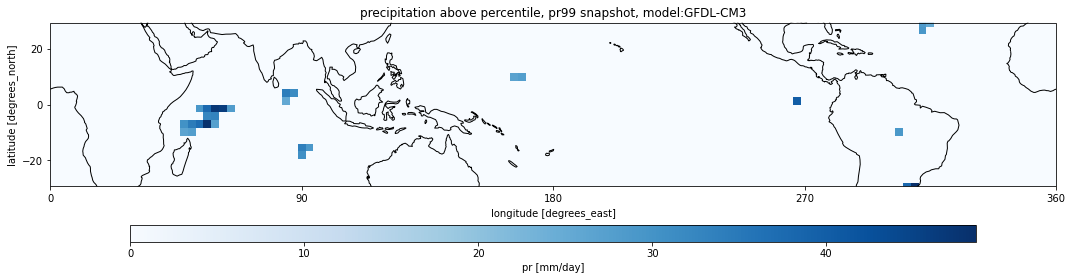

In [16]:
myPlots.plot_snapshot(precip.isel(time=0).where(precip.isel(time=0)>=pr_99[0],0), 'Blues', 'precipitation above percentile, pr99', model)

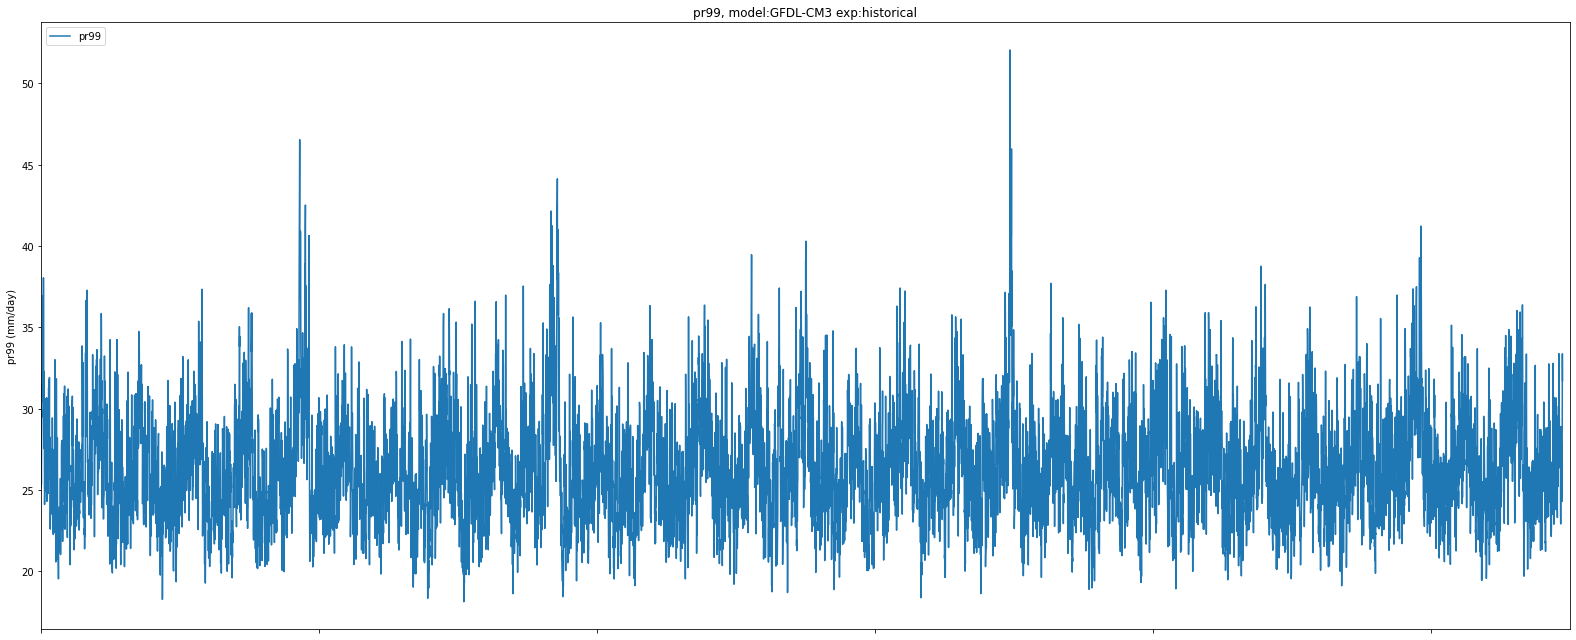

In [17]:
f, ax = plt.subplots(figsize=(22, 5))

da = xr.DataArray(pr_99.data)
da.plot(ax=ax, label='pr99', add_legend=True)
ax.set_title('pr99, model:' + model + ' exp:' + experiment)
ax.set_ylabel('pr99 (mm/day)')
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xlim(0, 11000)
ax.legend(loc = 'upper left')

plt.tight_layout()

# saving

In [18]:
folder = '/g/data/k10/cb4968/cmip5/' + model

In [19]:
# pr_snapshot, pr_tMean
save = False
if save:
    os.makedirs(folder, exist_ok=True)

    fileName = model + '_pr_example_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)    

    xr.Dataset({'pr_day': precip.isel(time=0), 'pr_tMean': precip.mean(dim='time', keep_attrs=True)}).to_netcdf(path)
    

In [20]:
# pr_test, for local
save = False
if save:
    os.makedirs(folder, exist_ok=True)
    
    fileName = model + '_pr4_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)    

    xr.Dataset({'pr4_days': precip.isel(time=slice(0,4))}).to_netcdf(path)

In [21]:
# Rx1day and Rx5day
save = False
if save:
    os.makedirs(folder, exist_ok=True)

    fileName = model + '_pr_rxday_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)

    xr.Dataset({'rx1day': rx1day, 'rx5day': rx5day}).to_netcdf(path) 

In [22]:
# high percentile precipitation
save = False
if save:
    folder = '/g/data/k10/cb4968/cmip5/' + model
    os.makedirs(folder, exist_ok=True)

    fileName = model + '_pr_percentile_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)

    xr.Dataset({'pr_95': pr_95, 'pr_97': pr_97, 'pr_99': pr_99, 'pr_999': pr_999}).to_netcdf(path) 

## checking

In [23]:
test = False
if test:
    fileName = model + '_pr_example_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds_local = xr.open_dataset(path)
    ds_local
